In [1]:
# @title Install dependencies
%pip install nilearn 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn import plotting

In [3]:
# The download cells will store the data in nested directories starting here:
DATA_DIR = "./hcp_retino"
if not os.path.isdir(DATA_DIR):
  os.mkdir(DATA_DIR)

# The data acquisition rate
TR = 1  # Time resolution, in sec

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquisition
RUN_NAMES = [
  "BAR1",   # Sweeping Bars repeat 1
  "BAR2",   # Sweeping Bars repeat 2
  "CCW",    # Counter Clockwise rotating wedge
  "CW",     # Clockwise rotating wedge
  "EXP",    # Expanding ring
  "CON"     # Contracting ring
]

In [5]:
import os
import tarfile

fname_ex = "HCP7T_retino"
path_name = os.path.join(DATA_DIR, fname_ex)
local_path = os.path.expanduser("~/Downloads/hcp_retino.tgz")  # <-- Your local file path

if not os.path.exists(path_name):
    print(f"Extracting from local file: {local_path}...")
    with tarfile.open(local_path) as fzip:
        fzip.extractall(DATA_DIR)
else:
    print(f"File {fname_ex}.tgz has already been extracted.")

Extracting from local file: /Users/jtu/Downloads/hcp_retino.tgz...


In [7]:
# pick a run
run = 'EXP'
# define filename
filename = os.path.expanduser(f"~/Downloads/HCP7T_retino/tfMRI_RET{run}_7T_AP.dtseries.nii")
# load the file with nibabel
cifti = nib.load(filename)

print(cifti.get_fdata().shape)

(300, 91282)


In [8]:
# Simple sinusoidal model
# The task timing is:
# 22 sec, 8 cycles x 32sec, 22 sec
n_before = 22
period = 32
cycles = 8
n_after = 22
t = np.arange(0, period * cycles, 1/TR)
time_var_cos = np.concatenate((np.zeros(n_before),
                               np.cos(2 * np.pi * t / period),
                               np.zeros(n_after)))
time_var_sin = np.concatenate((np.zeros(n_before),
                               np.sin(2 * np.pi * t / period),
                               np.zeros(n_after)))
# Create design matrix
design_matrix = np.asarray([time_var_cos,
                            time_var_sin,
                            np.ones_like(time_var_sin)]).T

In [9]:
# Invert model
beta = np.linalg.pinv(design_matrix) @ cifti.get_fdata()

In [10]:
angle = np.arctan2(beta[1, :],beta[0, :])
amplitude = np.sqrt(np.sum(beta[:1, :]**2, axis=0))

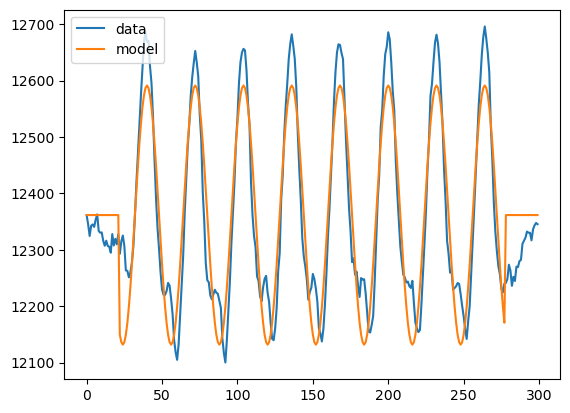

In [11]:
idx = np.argmax(amplitude)
data = cifti.get_fdata()[:, idx]
# Model prediction is M*beta
pred = design_matrix @ beta[:, idx]

plt.figure()
plt.plot(data, label='data')
plt.plot(pred, label='model')
plt.legend()
plt.show()

In [12]:
angle_map = np.arctan2(beta[1, :], beta[0, :])  # shape: (91282,)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
/var/folders/6j/4dfmtv_12fj9q312qyh1c7600000gn/T/ipykernel_17928/1292169733.py:24: DeprecationWarning: The `darkness` parameter will be deprecated in release 0.13. We recommend setting `darkness` to None
  plotting.plot_surf_stat_map(


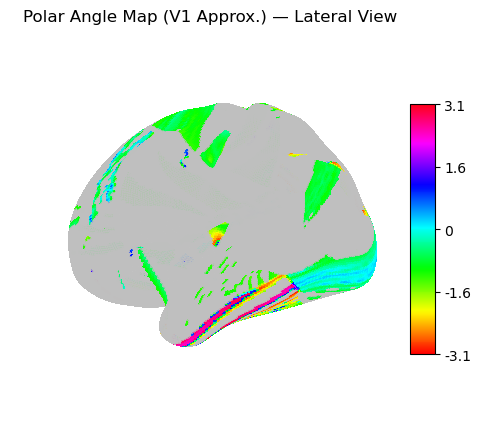

In [20]:
from nilearn import surface, plotting

# --- Load surface and angle map ---
n_vertices_hemi = 32492
lh_surf = './hcp_retino/HCP7T_retino/surf/Q1-Q6_R440.L.inflated.32k_fs_LR.surf.gii'
lh_mesh = surface.load_surf_mesh(lh_surf)
angle_lh = angle[:n_vertices_hemi]

# --- Load myelin map as proxy for V1 mask ---
myelin_file = './hcp_retino/HCP7T_retino/surf/Q1-Q6_R440.MyelinMap_BC.32k_fs_LR.dscalar.nii'
myelin = nib.load(myelin_file).get_fdata().squeeze()  # shape: (91282,)
myelin_lh = myelin[:n_vertices_hemi]

# --- Create V1-like mask (high myelin = early visual cortex) ---
threshold = np.percentile(myelin_lh, 75)  # top 15% most myelinated
v1_mask = myelin_lh > threshold

# --- Mask angle map ---
angle_v1 = np.zeros_like(angle_lh)
angle_v1[~v1_mask] = np.nan  # hide non-V1 areas
angle_v1[v1_mask] = angle_lh[v1_mask]

# --- Plot focused on occipital (outer back) surface ---
plotting.plot_surf_stat_map(
    surf_mesh=lh_mesh,
    stat_map=angle_v1,
    hemi='left',
    title='Polar Angle Map (V1 Approx.) — Lateral View',
    cmap='hsv',
    colorbar=True,
    bg_map=None,
    darkness=0.5,
    view='lateral'  # this shows the outer surface with occipital lobe
)
plt.show()

In [14]:
# Path to one of the runs (you can switch to other ones)
fmri_file = "./hcp_retino/HCP7T_retino/tfMRI_RETBAR1_7T_AP.dtseries.nii"

# Load the file
img = nib.load(fmri_file)
data = img.get_fdata()

print("Shape of fMRI data:", data.shape)

Shape of fMRI data: (300, 91282)


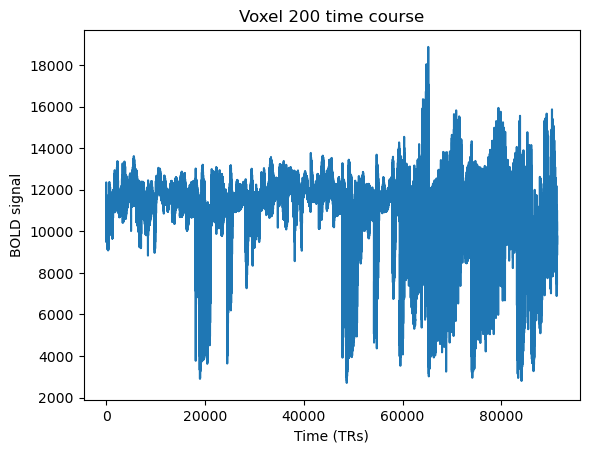

In [15]:
# Pick a grayordinate (e.g., 10000 = left V1 area)
grayordinate_idx = 200
timecourse = data[grayordinate_idx, :]

import matplotlib.pyplot as plt

plt.plot(timecourse)
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD signal")
plt.title(f"Voxel {grayordinate_idx} time course")
plt.show()

In [16]:
# Load stimulus video array
stim_file = "./hcp_retino/HCP7T_retino/stims/7T_RETCW.npy"
stim = np.load(stim_file)  # This will have shape (300, 288, 352, 3)
print("Stimulus shape:", stim.shape)

Stimulus shape: (300, 288, 352, 3)


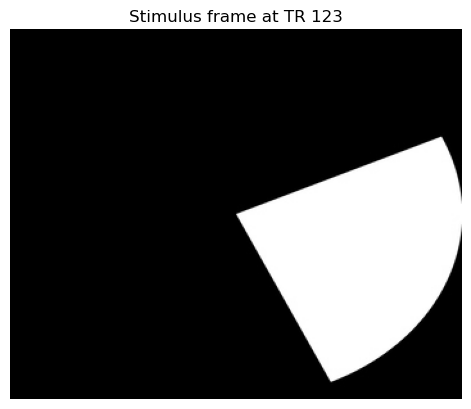

In [17]:
frame_idx = 123  # Any number between 0 and 299
frame = stim[frame_idx]

plt.imshow(frame)
plt.title(f"Stimulus frame at TR {frame_idx}")
plt.axis("off")
plt.show()